
# Try-It Activity 10.3: Building and Evaluating ARMA Models
The last videos of the module took you through an approach to building ARMA models.

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.

If you have trouble locating a dataset or would prefer a suggestion, try the Rossmann Store Sales (Links to an external site.) competition from Kaggle. This dataset involves forecasting retail store sales for a major drug store.


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

In [6]:
warnings.filterwarnings("ignore")

In [7]:
gd = pd.read_csv('data/gold_price_data.csv', delimiter = ',')

In [8]:
gd

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [9]:
gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


In [10]:
gd.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


In [11]:
gd

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [12]:
gold=gd.set_index(pd.to_datetime(gd['Date'])).drop('Date', axis=1)

In [13]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10787 entries, 1970-01-01 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   10787 non-null  float64
dtypes: float64(1)
memory usage: 168.5 KB


In [14]:
gold = gold['2010':]
gold

,Value
Date,
2010-01-01,1087.50
2010-01-04,1121.50
2010-01-05,1123.25
2010-01-06,1130.00
2010-01-07,1130.25
...,...
2020-03-09,1672.50
2020-03-10,1655.70
2020-03-11,1653.75


Text(0.5, 1.0, 'Daily Price of Gold 1970 - 2020')

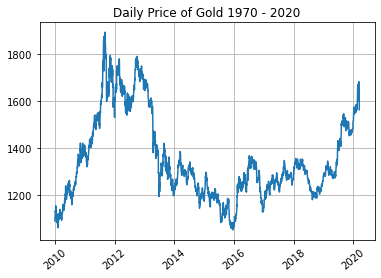

In [15]:
plt.plot(gold['Value'])
plt.grid()
plt.xticks(rotation = 40)
plt.title('Daily Price of Gold 1970 - 2020')

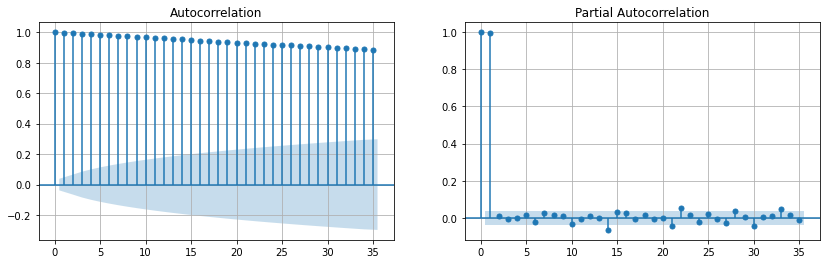

In [16]:
# plot ACF and PACF with plain series
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
# ACF
plot_acf(gold, ax = ax[0])
ax[0].grid()
# PACF
plot_pacf(gold, ax = ax[1])
ax[1].grid()

In [17]:
# check stationarity by Dickey Fuller at different thresholds
#adf_results = adfuller(results.resid.diff().dropna()) # check alternative if below is not stationary
adf_results = adfuller(gold)
print('ADF Statistic: %f' % adf_results[0])
print('p-value: %f' % adf_results[1], 'stationary' if (adf_results[1] <= 0.05) else 'not stationary')
print('Critical Values:')
for key, value in adf_results[4].items():
    print('\t%s: %.3f' % (key, value), 'stationary' if (adf_results[0] < value) else 'not stationary')
adf_results

ADF Statistic: -1.911278
p-value: 0.326774 not stationary
Critical Values:
	1%: -3.433 not stationary
	5%: -2.863 not stationary
	10%: -2.567 not stationary


(-1.911278150563643,
 0.3267742550621934,
 24,
 2636,
 {'1%': -3.4328331864239274,
  '5%': -2.8626370834536976,
  '10%': -2.56735401579277},
 21243.310757239797)

In [18]:
# do diff and dropna
gold_df = gold.diff().dropna()

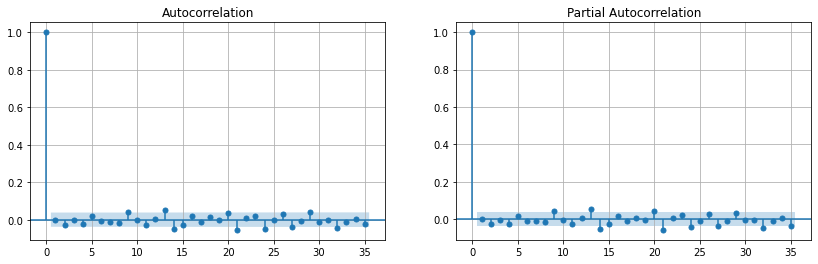

In [19]:
# plot ACF and PACF with plain series
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
# ACF
plot_acf(gold_df, ax = ax[0])
ax[0].grid()
# PACF
plot_pacf(gold_df, ax = ax[1])
ax[1].grid()

In [20]:
y_hist, y_future = gold_df[:-30], gold_df[-30:]

In [21]:
# check if differenced data is stationary
adf_results = adfuller(y_hist)
print('ADF Statistic: %f' % adf_results[0])
print('p-value: %f' % adf_results[1], 'stationary' if (adf_results[1] <= 0.05) else 'not stationary')
print('Critical Values:')
for key, value in adf_results[4].items():
    print('\t%s: %.3f' % (key, value), 'stationary' if (adf_results[0] < value) else 'not stationary')
adf_results

ADF Statistic: -10.779318
p-value: 0.000000 stationary
Critical Values:
	1%: -3.433 stationary
	5%: -2.863 stationary
	10%: -2.567 stationary


(-10.779317561740486,
 2.2765910053052712e-19,
 23,
 2606,
 {'1%': -3.43286180083873,
  '5%': -2.8626497201105283,
  '10%': -2.5673607436289947},
 20948.543283995)

<function matplotlib.pyplot.show(close=None, block=None)>

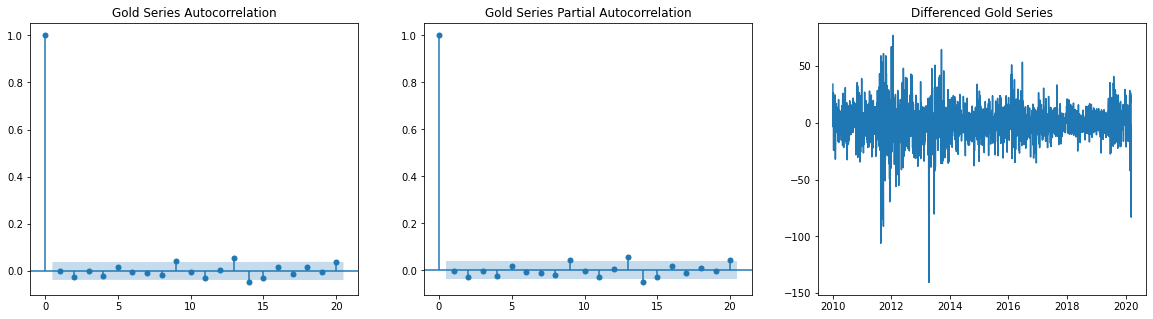

In [22]:
# plot charts
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
plot_acf(gold_df, lags=20, ax = ax[0])
ax[0].set_title('Gold Series Autocorrelation')
plot_pacf(gold_df, lags=20, ax = ax[1])
ax[1].set_title('Gold Series Partial Autocorrelation')
ax[2].plot(gold_df)
ax[2].set_title('Differenced Gold Series')
plt.show

In [23]:
gold_df.iloc[0]

Value    34.0
Name: 2010-01-04 00:00:00, dtype: float64

Text(0.5, 1.0, 'Daily Price of Gold 1970 - 2020')

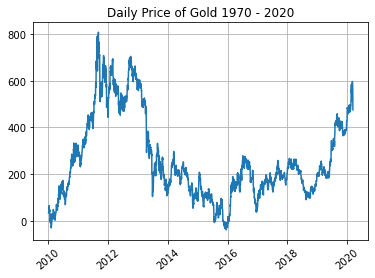

In [24]:
# add first point which was dropped by dropna() b/c it starts at 0
plt.plot(gold_df.cumsum())
plt.grid()
plt.xticks(rotation = 40)
plt.title('Daily Price of Gold 1970 - 2020')

In [36]:
# build ARMA model & fit
arma = ARIMA(y_hist, order = (3, 1, 3)).fit()

In [37]:
hist_preds = arma.predict()

In [38]:
hist_preds.cumsum()

2010-01-04       0.000000
2010-01-05      33.993652
2010-01-06      51.943599
2010-01-07      66.129507
2010-01-08      76.997642
                 ...     
2020-01-27    1165.385791
2020-01-28    1165.479411
2020-01-29    1165.967774
2020-01-30    1165.593808
2020-01-31    1166.543862
Freq: B, Name: predicted_mean, Length: 2630, dtype: float64

2020-01-27   -0.109158
2020-01-28    0.093619
2020-01-29    0.488363
2020-01-30   -0.373966
2020-01-31    0.950054
Freq: B, Name: predicted_mean, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

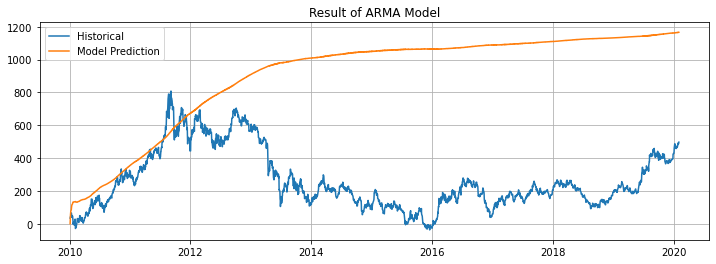

In [39]:
# Results
print(hist_preds.tail())
plt.figure(figsize = (12, 4))
plt.plot(y_hist.cumsum(), label = 'Historical')
plt.plot(hist_preds.cumsum(), label = 'Model Prediction')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model')
plt.show

In [40]:
# forecast
forecast = arma.forecast(len(y_future))
# set index same as y_future!
forecast.index=y_future.index
#mse_test = mean_squared_error(y_future['Value'], forecast)
pred_error = y_future['Value'] - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt(np.square(pred_error).mean())
rmse2 = np.sqrt(mean_squared_error(y_future['Value'], forecast))

# results
print(forecast[:5], len(forecast))
print('Size:', len(forecast))
# Results
print(f'MAE   : {mae}')
print(f'RMSE  : {rmse}')
print(f'RMSE2 : {rmse2}')

Date
2020-02-03   -0.688281
2020-02-04    0.895617
2020-02-05   -0.268461
2020-02-06    0.311563
2020-02-07    0.417963
Name: predicted_mean, dtype: float64 30
Size: 30
MAE   : 15.996836921074223
RMSE  : 22.06400367601438
RMSE2 : 22.064003676014384


<function matplotlib.pyplot.show(close=None, block=None)>

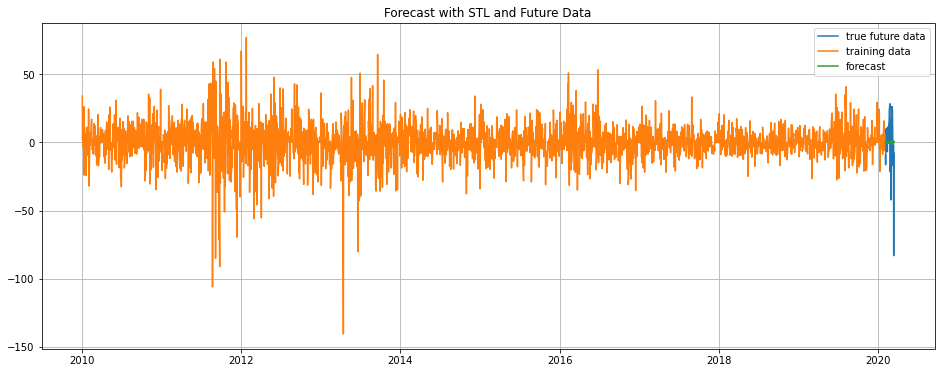

In [41]:
# Entire series with forecast
plt.subplots(figsize=(16,6))
plt.plot(y_future, label = 'true future data')
plt.plot(y_hist, label = 'training data')
plt.plot(forecast, label = 'forecast')
plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid()
plt.show

In [42]:
#y_future

In [43]:
#forecast.index=y_future.index

<function matplotlib.pyplot.show(close=None, block=None)>

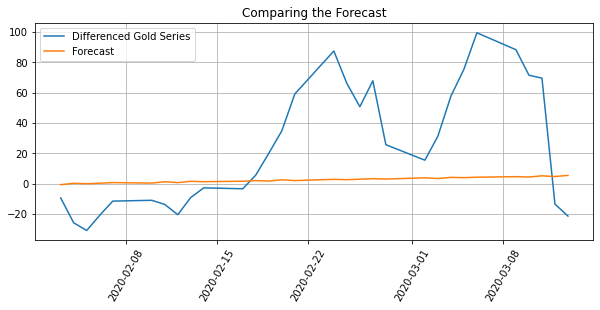

In [44]:
plt.subplots(figsize=(10,4))
plt.plot(y_future.cumsum(), label = 'Differenced Gold Series')
plt.plot(forecast.cumsum(), label = 'Forecast')
plt.title('Comparing the Forecast')
plt.legend()
plt.xticks(rotation = 60)
plt.grid()
plt.show

In [34]:
def arma_grid_search(data, p_values, d_values, q_values):
    # split data
    y_hist, y_future = data[:-30], data[-30:]
    best_rmse, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                arima_order = (p, d, q)
                # build ARMA model & fit
                arma = ARIMA(y_hist, order = arima_order).fit()
                hist_preds = arma.predict()

                # forecast
                forecast = arma.forecast(len(y_future))
                # set index same as y_future!
                forecast.index=y_future.index

                pred_error = y_future['Value'] - forecast
                mae = np.abs(pred_error).mean()
                rmse = np.sqrt(np.square(pred_error).mean())
                print('ARIMA Order=%s MSE=%.3f' % (arima_order, rmse))
                if rmse < best_rmse:
                    best_rmse, best_config = rmse, arima_order

    # Results
    print('Best ARIMA Order=%s MSE=%.3f' % (best_config, best_rmse))

In [35]:
# seed values from PACF plot!
p_values = [1, 3, 6, 9, 13, 14]
d_values = [0, 1]
q_values = [3, 9]
arma_grid_search(gold_df, p_values, d_values, q_values)

ARIMA Order=(3, 0, 3) MSE=22.189
ARIMA Order=(3, 0, 9) MSE=22.122
ARIMA Order=(3, 1, 3) MSE=22.064
ARIMA Order=(3, 1, 9) MSE=22.158
ARIMA Order=(9, 0, 3) MSE=22.122
ARIMA Order=(9, 0, 9) MSE=22.170
ARIMA Order=(9, 1, 3) MSE=22.179
ARIMA Order=(9, 1, 9) MSE=22.176
ARIMA Order=(11, 0, 3) MSE=22.130
ARIMA Order=(11, 0, 9) MSE=22.134
ARIMA Order=(11, 1, 3) MSE=22.207
ARIMA Order=(11, 1, 9) MSE=22.131
ARIMA Order=(13, 0, 3) MSE=22.121
ARIMA Order=(13, 0, 9) MSE=22.104
ARIMA Order=(13, 1, 3) MSE=22.205
ARIMA Order=(13, 1, 9) MSE=22.065
Best ARIMA Order=(3, 1, 3) MSE=22.064


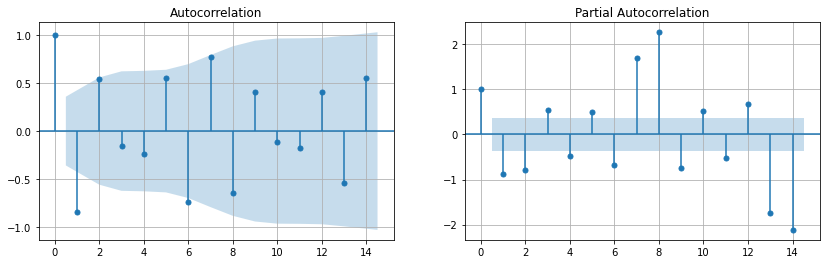

In [47]:
# log
# plot ACF and PACF with plain series
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
plot_acf(forecast, ax = ax[0], lags=14)
ax[0].grid()
plot_pacf(forecast, ax = ax[1], lags=14)
ax[1].grid()